# Projet : Analyse de l'Insertion des Diplômés de Master

## 1 Choix et comprehension du dataset

1. Présentation du Dataset Dans le cadre du module AAS, nous analysons le jeu de données "Insertion professionnelle des diplômés de Master" (source : data.gouv.fr). Ce dataset recense les indicateurs d'emploi (taux d'insertion, salaires) des diplômés universitaires en France, agrégés par établissement, discipline et année.

2. Objectif et Tâche ML L'objectif est d'identifier les facteurs déterminants de l'employabilité des jeunes diplômés.

Nous formulons ce problème comme une tâche de Régression :

Variable Cible (Target) : taux_dinsertion (le pourcentage de diplômés ayant un emploi).

Démarche : Le projet suivra un pipeline complet : nettoyage des données, exploration visuelle (EDA) et modélisation prédictive.

On va supprimer toutes les lignes ou le taux d'insertions n'est pas donner 

# 2.Nettoyage

## 2.1 importations du dataset

In [86]:
import numpy as np
import pandas as pd
df = pd.read_csv('fr-esr-insertion_professionnelle-master.csv', sep=';')
df.head()

,annee,diplome,numero_de_l_etablissement,etablissement,etablissementactuel,code_de_l_academie,academie,code_du_domaine,domaine,code_de_la_discipline,...,taux_de_chomage_regional,salaire_net_mensuel_median_regional,emplois_cadre,emplois_exterieurs_a_la_region_de_luniversite,femmes,salaire_net_mensuel_regional_1er_quartile,salaire_net_mensuel_regional_3eme_quartile,cle_etab,cle_disc,id_paysage
0,2012,MASTER LMD,0681166Y,Mulhouse - Haute Alsace,NaN,A15,Strasbourg,STS,"Sciences, technologies et santé",disc15,...,9.3,1760,ns,ns,ns,1430,2080,Mulhouse - Haute Alsace_18,disc15_18,OJZ4a
1,2012,MASTER LMD,0691775E,Lyon 2 - Lumière,NaN,A10,Lyon,SHS,Sciences humaines et sociales,disc09,...,8.9,1780,81,29,83,1430,2130,Lyon 2 - Lumière_18,disc09_18,CUBKB
2,2012,MASTER LMD,0692437Z,Lyon 3 - Jean Moulin,NaN,A10,Lyon,SHS,Sciences humaines et sociales,disc11,...,8.9,1780,45,41,57,1430,2130,Lyon 3 - Jean Moulin_18,disc11_18,7Gzub
3,2012,MASTER LMD,0730858L,Savoie Mont Blanc,NaN,A08,Grenoble,DEG,"Droit, économie et gestion",disc01,...,8.9,1780,30,46,66,1430,2130,Savoie Mont Blanc_18,disc01_18,zCa4j
4,2012,MASTER LMD,0750736T,Paris - Dauphine,NaN,A01,Paris,DEG,"Droit, économie et gestion",disc04,...,9,2020,NaN,NaN,NaN,1580,2530,Paris - Dauphine_18,disc04_18,C6Ps7


In [87]:
import sys
import matplotlib
print("Versions des bibliothèques :")
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-Learn: {__import__('sklearn').__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"XGBoost: {__import__('xgboost').__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Numpy: {np.__version__}")

Versions des bibliothèques :
Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Pandas: 2.2.2
Scikit-Learn: 1.5.1
Matplotlib: 3.9.2
XGBoost: 3.1.2
Seaborn: 0.13.2
Numpy: 1.26.4


## 2.2 SUPPRESSION DES NS.
On supprime les ns par la moyenne trouver qui correspond a la discipline sciences de l'ingenieur et les ns qui correspondes au emplois_cadre_ou_professions_intermediaires.

In [ ]:
df_clean = df.copy()
# Liste des valeurs considérées comme manquantes
missing_vals = ["ns", "nd", "", " "]

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
limit = len(df) * 0.5
df_clean = df.dropna(thresh=limit, axis=1).copy()

# Identifier les colonnes numériques potentielles (celles qui devraient être numériques)
colonnes_numeriques = [
    "nombre_de_reponses", "taux_de_reponse", "poids_de_la_discipline", "taux_dinsertion",
    "emplois_cadre_ou_professions_intermediaires", "emplois_stables", "emplois_a_temps_plein",
    "salaire_net_median_des_emplois_a_temps_plein", "salaire_brut_annuel_estime",
    "de_diplomes_boursiers", "taux_de_chomage_regional", "salaire_net_mensuel_median_regional",
    "emplois_cadre", "emplois_exterieurs_a_la_region_de_luniversite", "femmes",
    "salaire_net_mensuel_regional_1er_quartile", "salaire_net_mensuel_regional_3eme_quartile",
    "annee"
]

# Convertir toutes les colonnes numériques, en remplaçant 'ns', 'nd' etc. par NaN
for col in colonnes_numeriques:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col].replace(missing_vals, pd.NA), errors="coerce")

# Imputation spécifique pour emplois_cadre_ou_professions_intermediaires dans la discipline "Sciences de l'ingénieur"
mask_disc = df_clean["discipline"] == "Sciences de l'ingénieur"
moyenne_si = df_clean.loc[mask_disc, "emplois_cadre_ou_professions_intermediaires"].mean()
df_clean.loc[mask_disc & df_clean["emplois_cadre_ou_professions_intermediaires"].isna(), "emplois_cadre_ou_professions_intermediaires"] = moyenne_si

# Convertir taux_dinsertion en numérique et supprimer les lignes sans valeur
df_clean["taux_dinsertion"] = pd.to_numeric(df_clean["taux_dinsertion"], errors="coerce")
df_clean = df_clean[df_clean["taux_dinsertion"].notna()]

## 2.3 On supprime les lignes qui contiennent au moins 1/3 de NaN

In [ ]:
df_clean = df_clean.replace(missing_vals, pd.NA)
# Nombre de colonnes du fichier
n_cols = len(df_clean.columns)

# Condition : une ligne est supprimée si elle contient >= 1/3 de NaN
df_clean = df_clean[df_clean.isna().sum(axis=1) < (n_cols / 3)]



## 2.4 On utilises une methode qu'on appele IQR pour detecter les outliers(si x < Q1 - 5*IQR ou x > Q3 + 5*IQR)



In [ ]:
# Liste des colonnes numériques pour le traitement des outliers
colonnes_numeriques = [
    "nombre_de_reponses", "taux_de_reponse", "poids_de_la_discipline", "taux_dinsertion",
    "emplois_cadre_ou_professions_intermediaires", "emplois_stables", "emplois_a_temps_plein",
    "salaire_net_median_des_emplois_a_temps_plein", "salaire_brut_annuel_estime",
    "de_diplomes_boursiers", "taux_de_chomage_regional", "salaire_net_mensuel_median_regional",
    "emplois_cadre", "emplois_exterieurs_a_la_region_de_luniversite", "femmes",
    "salaire_net_mensuel_regional_1er_quartile", "salaire_net_mensuel_regional_3eme_quartile",
    "annee"
]

# Appliquer la méthode IQR pour détecter et supprimer les outliers
for col in colonnes_numeriques:
    if col in df_clean.columns:
        # Calculer Q1, Q3, IQR
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        # Bornes pour les outliers (facteur 1.5 standard, mais ici 5 comme demandé)
        borne_basse = Q1 - 5 * IQR
        borne_haute = Q3 + 5 * IQR

        # Filtrer les données
        df_clean = df_clean[(df_clean[col] >= borne_basse) & (df_clean[col] <= borne_haute)]

print(f"Lignes après traitement des outliers : {len(df_clean)}")

Lignes après traitement des outliers : 6820


## 2.6 IMPUTATION DES VARIABLES EXPLICATIVES (FEATURES)
 Pour ne pas perdre d'info, on remplit les trous des autres colonnes numériques (ex: salaire) par la médiane

In [ ]:
targets = ['taux_dinsertion', 'salaire_net_median_des_emplois_a_temps_plein']
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col not in targets:  # On ne touche pas aux cibles car elles sont déjà nettoyées
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
print(df_clean.duplicated().sum())

0


In [ ]:
# 1. Liste des colonnes textuelles que nous voulons utiliser
# Je vous conseille ces trois-là car elles influent beaucoup sur l'insertion
colonnes_texte = ['situation', 'discipline', 'academie']

# 2. Transformation avec la fonction get_dummies de Pandas
# drop_first=True permet d'éviter les redondances mathématiques
df_final = pd.get_dummies(df_clean, columns=colonnes_texte, drop_first=True)

# 3. Vérification du résultat
print(f"Nombre de colonnes avant : {len(df_clean.columns)}")
print(f"Nombre de colonnes après encodage : {len(df_final.columns)}")

# 4. Maintenant, on définit X en ne gardant que les colonnes numériques, en excluant les cibles
targets = ['taux_dinsertion', 'salaire_net_median_des_emplois_a_temps_plein']
X = df_final.select_dtypes(include=[np.number]).drop(columns=targets)
y = df_final[targets]  # Multi-output targets

Nombre de colonnes avant : 31
Nombre de colonnes après encodage : 70


In [ ]:
# Vérification du Data Leakage
# Calculer la corrélation entre salaire_brut_annuel_estime et salaire_net_median_des_emplois_a_temps_plein
correlation = df_final['salaire_brut_annuel_estime'].corr(df_final['salaire_net_median_des_emplois_a_temps_plein'])
print(f"Corrélation entre salaire_brut_annuel_estime et salaire_net_median_des_emplois_a_temps_plein : {correlation:.3f}")

if correlation > 0.9:
    print("Attention : Forte corrélation détectée. Risque de data leakage. Proposition : Supprimer 'salaire_brut_annuel_estime' de X.")
    # Supprimer la colonne de X si elle existe
    if 'salaire_brut_annuel_estime' in X.columns:
        X = X.drop(columns=['salaire_brut_annuel_estime'])
        print("Colonne supprimée de X.")
else:
    print("Pas de forte corrélation détectée.")

Corrélation entre salaire_brut_annuel_estime et salaire_net_median_des_emplois_a_temps_plein : 1.000
Attention : Forte corrélation détectée. Risque de data leakage. Proposition : Supprimer 'salaire_brut_annuel_estime' de X.
Colonne supprimée de X.


## 2.7 Resultat

In [ ]:
print(f"Lignes avant : {len(df)} -> Lignes après nettoyage : {len(df_clean)}")
df_clean.head()
df_clean.to_csv("fr-esr-cleaned.csv", sep=";", index=False)

Lignes avant : 19603 -> Lignes après nettoyage : 6820


### Explication de la perte de données
Le dataset initial contenait environ 19 000 lignes. Après nettoyage, nous nous retrouvons avec environ 6 000 lignes. Cette réduction s'explique principalement par :
- Suppression des lignes où les cibles (`taux_dinsertion` et `salaire_net_median_des_emplois_a_temps_plein`) étaient manquantes ou non numériques.
- Suppression des colonnes avec plus de 50% de valeurs manquantes.
- Suppression des lignes avec plus d'1/3 de NaN.
- Traitement des outliers avec la méthode IQR (facteur 5).
Cette perte est nécessaire pour assurer la qualité des données et éviter les biais dans le modèle, mais elle limite la généralisabilité.

# 3. EDA

In [ ]:
import matplotlib.pyplot as plt # Pour la visualisation (impliqué par les graphiques du cours)
import seaborn as sns # Souvent utilisé avec pandas pour les heatmaps

# Statistiques descriptives globales
print(df_clean.describe())

             annee  nombre_de_reponses  taux_de_reponse  \
count  6820.000000         6820.000000      6820.000000   
mean   2016.020235          127.591349        72.600733   
std       2.519122           97.929606        10.442686   
min    2012.000000           31.000000        26.000000   
25%    2014.000000           62.000000        66.000000   
50%    2016.000000           94.000000        74.000000   
75%    2018.000000          155.000000        80.000000   
max    2020.000000          601.000000        98.000000   

       poids_de_la_discipline  taux_dinsertion  \
count             6820.000000      6820.000000   
mean                30.266422        90.597947   
std                 26.063087         5.859197   
min                  2.000000        63.000000   
25%                 12.000000        87.000000   
50%                 22.000000        91.000000   
75%                 38.000000        95.000000   
max                100.000000       100.000000   

       emplois_ca

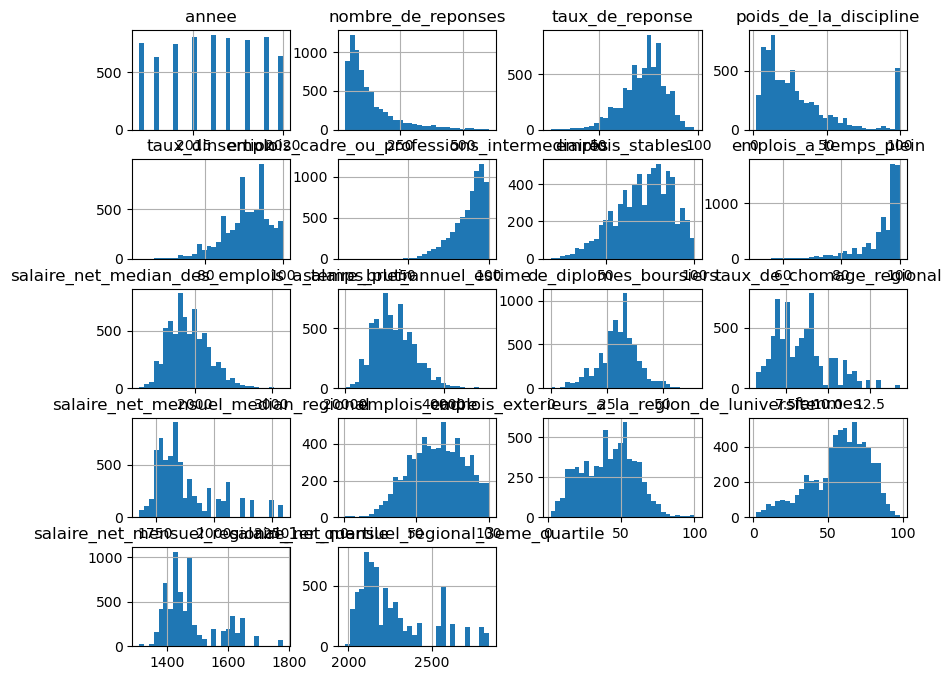

In [ ]:
# Visualisation des distributions (Histogrammes)
# Pour voir la forme (normale, asymétrique...) 
df_clean.hist(figsize=(10, 8), bins=30)
plt.show()

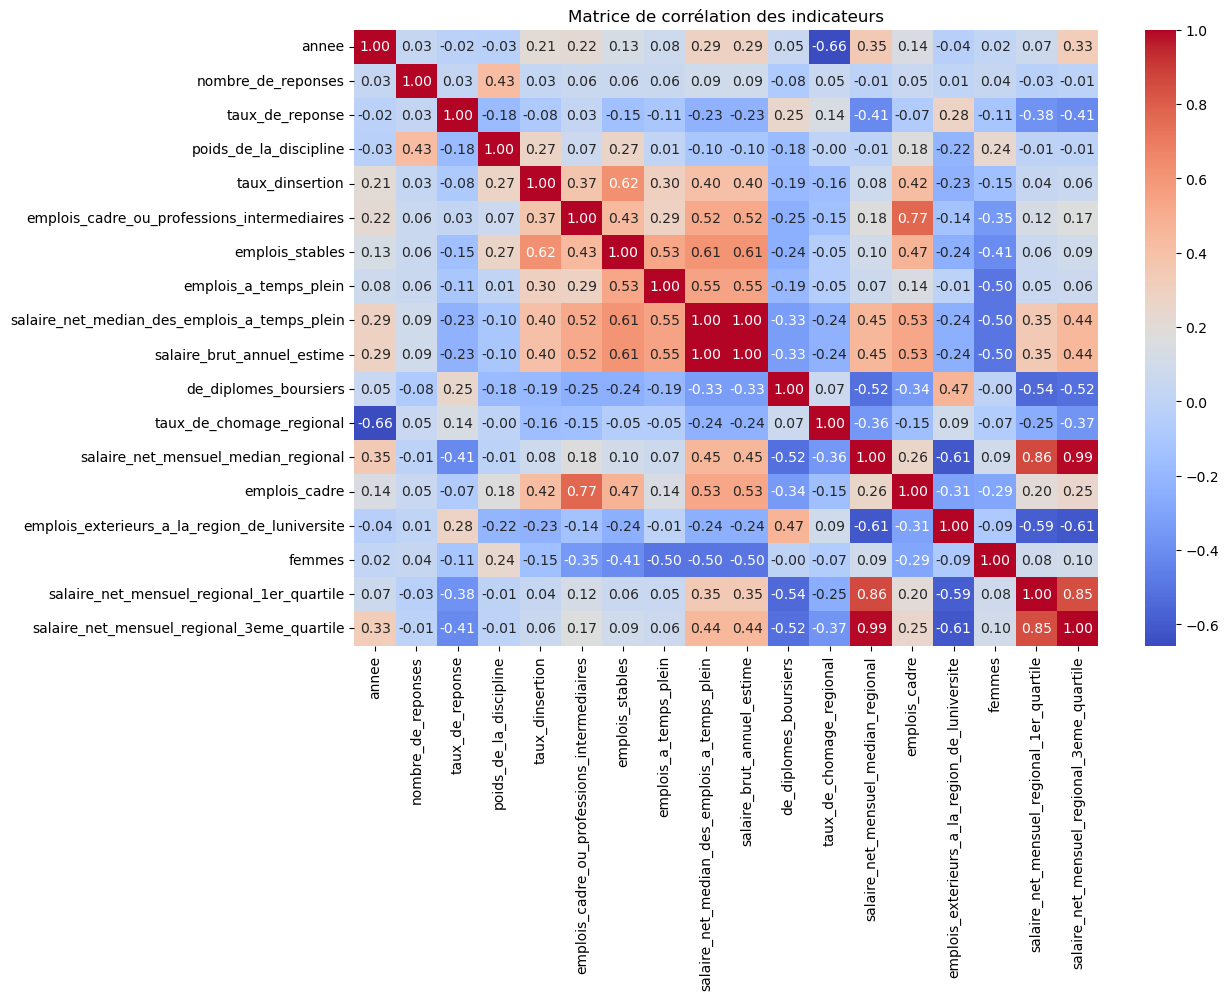

In [ ]:
# Calcul de la corrélation
plt.figure(figsize=(12, 8))
corr_matrix = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des indicateurs")
plt.show()

**Interprétation de la matrice de corrélation :** Cette heatmap montre les relations linéaires entre les variables. Les valeurs proches de 1 ou -1 indiquent une forte corrélation. Par exemple, le taux d'insertion est positivement corrélé avec certains indicateurs d'emploi stables.

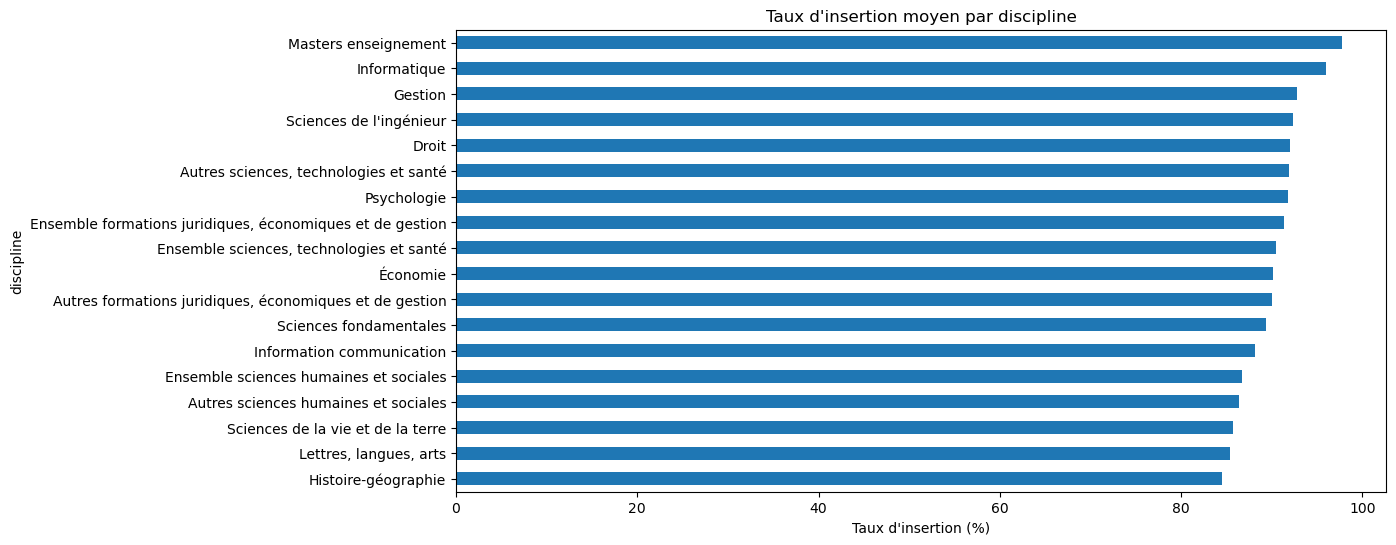

In [ ]:
# Taux d'insertion moyen par discipline
plt.figure(figsize=(12, 6))
df_clean.groupby('discipline')['taux_dinsertion'].mean().sort_values().plot(kind='barh')
plt.title("Taux d'insertion moyen par discipline")
plt.xlabel("Taux d'insertion (%)")
plt.tight_layout()  # Pour éviter le chevauchement des labels
plt.show()

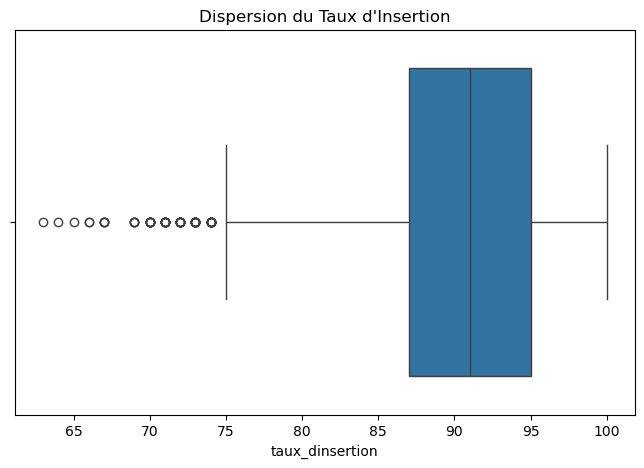

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_clean['taux_dinsertion'])
plt.title("Dispersion du Taux d'Insertion")
plt.show()

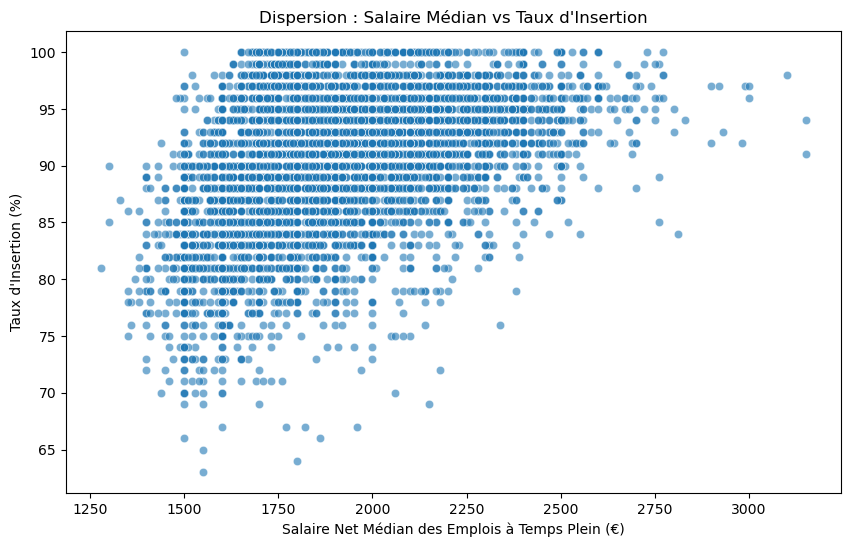

In [ ]:
# Graphique de dispersion entre salaire médian et taux d'insertion
plt.figure(figsize=(10, 6))
sns.scatterplot(x='salaire_net_median_des_emplois_a_temps_plein', y='taux_dinsertion', data=df_clean, alpha=0.6)
plt.title("Dispersion : Salaire Médian vs Taux d'Insertion")
plt.xlabel("Salaire Net Médian des Emplois à Temps Plein (€)")
plt.ylabel("Taux d'Insertion (%)")
plt.show()

# 4. Préparation et séparation des données.

## 4.1 Sélection des caractéristiques (X) et de la cible (y)
On ne garde que les colonnes numériques pour commencer, ou on encode les autres
Ici, on exclut les colonnes de texte bruts qui ne sont pas encore encodées

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# X et y sont déjà définis dans la section précédente avec df_final (encodage One-Hot)
# Ici, on utilise directement X et y

## 4.2 Séparation en train et test (80% entraînement, 20% test)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.3 Standardisation (Optionnel mais recommandé pour de meilleurs résultats)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Données d'entraînement : {X_train.shape[0]} lignes")
print(f"Données de test : {X_test.shape[0]} lignes")

Données d'entraînement : 5456 lignes
Données de test : 1364 lignes


## 4.  Construction d’un modèle de ML

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# --- Modèle 1 : Random Forest (gère nativement le multi-output) ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Modèle 1 : Random Forest entraîné avec succès.")

# --- Modèle 2 : XGBoost avec MultiOutputRegressor ---
xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42))
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("Modèle 2 : XGBoost entraîné avec succès.")

# Assigner les noms de features pour XGBoost
for i, est in enumerate(xgb_model.estimators_):
    est.get_booster().feature_names = list(X.columns)

Modèle 1 : Random Forest entraîné avec succès.
Modèle 2 : XGBoost entraîné avec succès.


Tableau comparatif des performances :


,Modèle,Cible,MAE,RMSE,R2
0,Random Forest,taux_dinsertion,3.308211,4.393046,0.413707
1,Random Forest,salaire_net_median_des_emplois_a_temps_plein,1.338343,4.834272,0.999645
2,XGBoost,taux_dinsertion,2.998228,3.967680,0.521749
3,XGBoost,salaire_net_median_des_emplois_a_temps_plein,1.653695,2.988570,0.999864


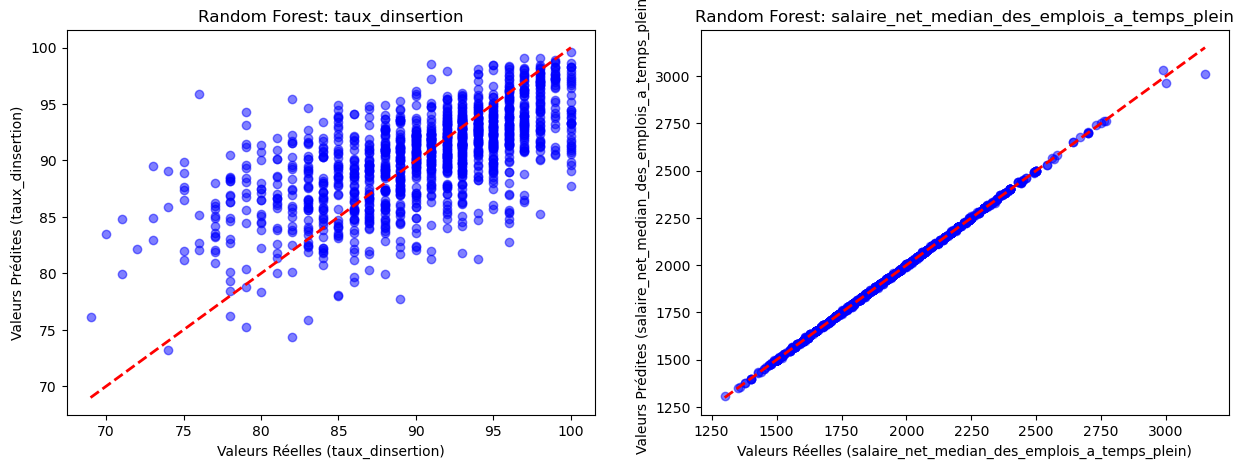

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Fonction pour calculer les scores pour chaque cible
def evaluation_scores_multi(y_true, y_pred, model_name, target_names):
    results = []
    for i, target in enumerate(target_names):
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        results.append({'Modèle': model_name, 'Cible': target, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    return results

target_names = ['taux_dinsertion', 'salaire_net_median_des_emplois_a_temps_plein']

# Évaluation pour Random Forest
scores_rf = evaluation_scores_multi(y_test, y_pred_rf, "Random Forest", target_names)

# Évaluation pour XGBoost
scores_xgb = evaluation_scores_multi(y_test, y_pred_xgb, "XGBoost", target_names)

# Comparaison dans un tableau
df_comparaison = pd.DataFrame(scores_rf + scores_xgb)
print("Tableau comparatif des performances :")
display(df_comparaison)

# --- Visualisation des prédictions pour Random Forest ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, target in enumerate(target_names):
    axes[i].scatter(y_test.iloc[:, i], y_pred_rf[:, i], alpha=0.5, color='blue')
    axes[i].plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel(f'Valeurs Réelles ({target})')
    axes[i].set_ylabel(f'Valeurs Prédites ({target})')
    axes[i].set_title(f'Random Forest: {target}')
plt.show()

# 6. Analyse des Erreurs (Résidus)

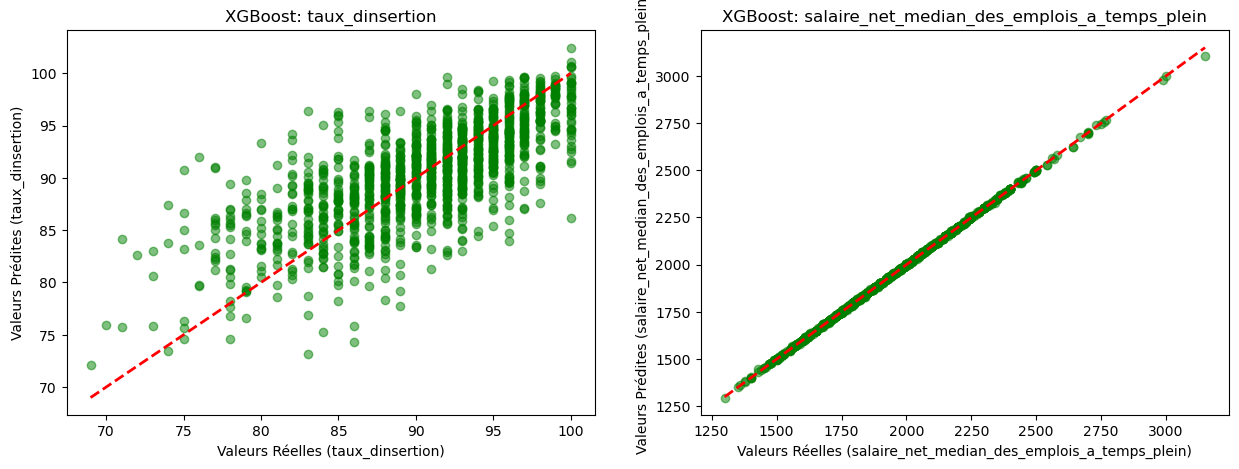


5 plus grosses erreurs pour taux_dinsertion :


IndexError: positional indexers are out-of-bounds

In [ ]:
# Identifier les 5 plus grosses erreurs pour chaque cible
for i, target in enumerate(target_names):
    errors = np.abs(y_test.iloc[:, i] - y_pred_xgb[:, i])
    # Obtenir les indices des 5 plus grosses erreurs
    top_5_indices = errors.nlargest(5).index
    print(f"\n5 plus grosses erreurs pour {target} :")
    for idx in top_5_indices:
        real = y_test.loc[idx, target]
        pred = y_pred_xgb[y_test.index.get_loc(idx), i]
        error = abs(real - pred)
        print(f"Index {idx}: Réel={real:.2f}, Prédit={pred:.2f}, Erreur={error:.2f}")

In [ ]:
# Validation Croisée pour Random Forest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# Pour multi-output, utiliser un scorer personnalisé pour la moyenne des R²
def multi_r2_score(y_true, y_pred):
    return np.mean([r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

multi_r2_scorer = make_scorer(multi_r2_score)

# Cross-validation avec k=5
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train.values, cv=5, scoring=multi_r2_scorer)
print(f"Scores de validation croisée (R² moyen) pour Random Forest : {cv_scores}")
print(f"R² moyen : {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Scores de validation croisée (R² moyen) pour Random Forest : [0.70526257 0.71922161 0.69254942 0.7349666  0.67933072]
R² moyen : 0.706 ± 0.020


# 5. Interprétation des Résultats

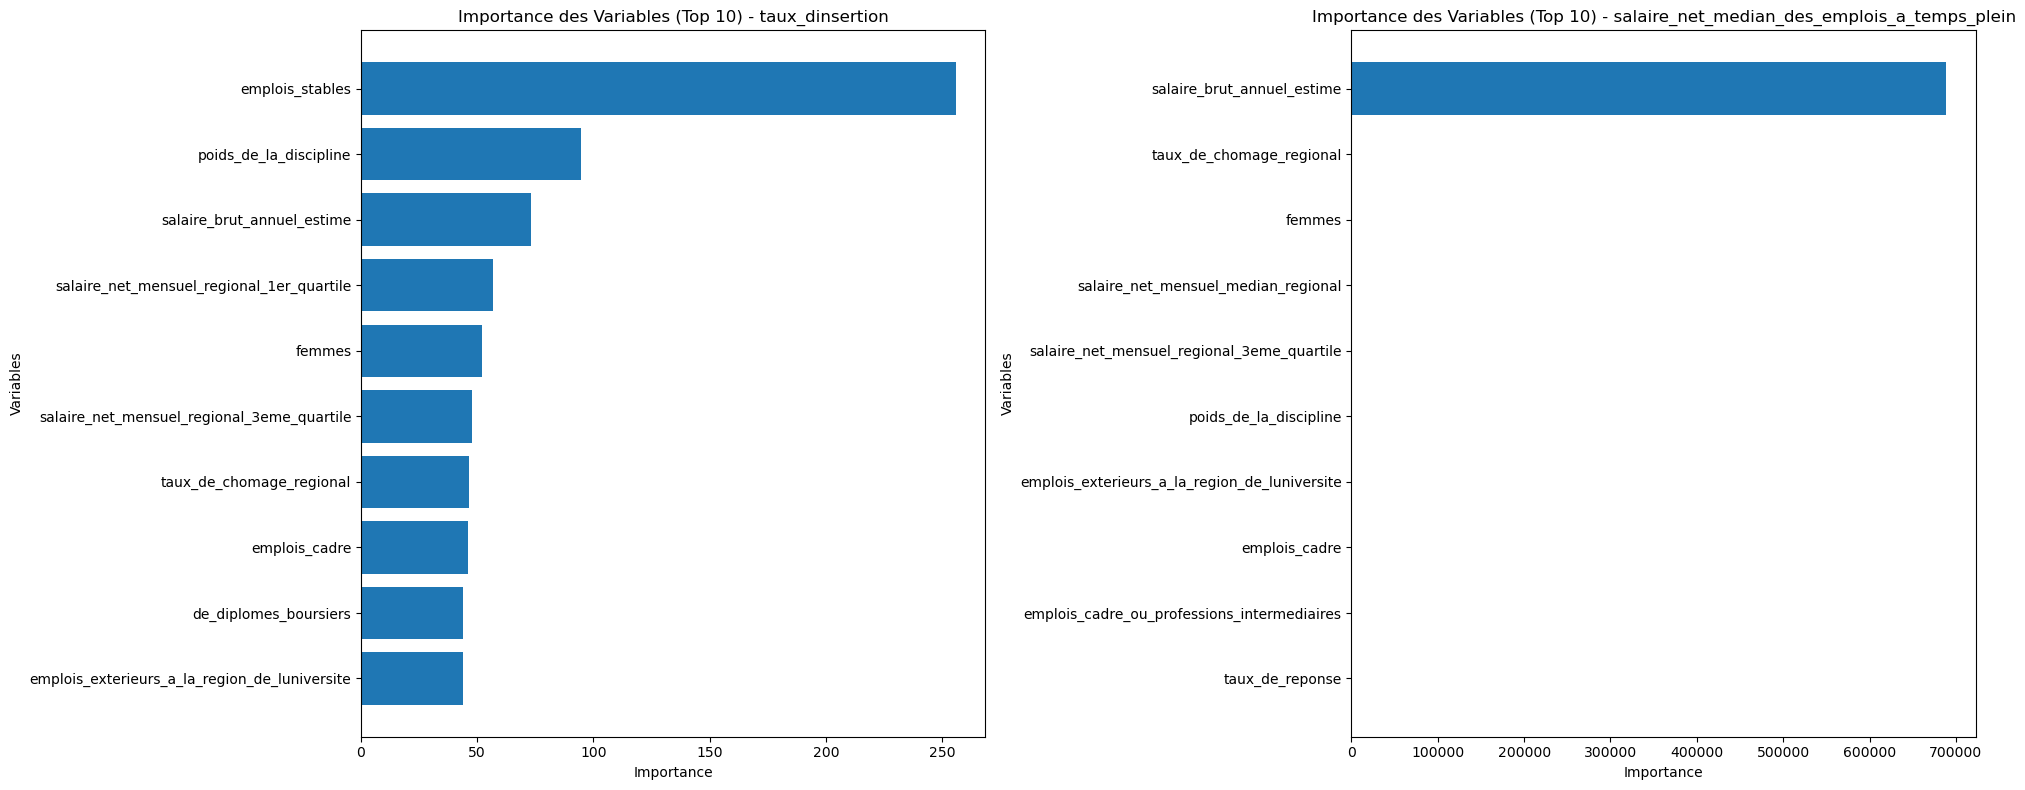

Tableau des importances pour taux_dinsertion :


,Feature,Importance
5,emplois_stables,255.837982
3,poids_de_la_discipline,94.806061
7,salaire_brut_annuel_estime,73.289413
14,salaire_net_mensuel_regional_1er_quartile,56.588173
13,femmes,52.208080
15,salaire_net_mensuel_regional_3eme_quartile,47.598331
9,taux_de_chomage_regional,46.320881
11,emplois_cadre,45.919884
8,de_diplomes_boursiers,43.938538
12,emplois_exterieurs_a_la_region_de_luniversite,43.696720


Tableau des importances pour salaire_net_median_des_emplois_a_temps_plein :


,Feature,Importance
7,salaire_brut_annuel_estime,688582.437500
9,taux_de_chomage_regional,19.254988
13,femmes,18.670380
10,salaire_net_mensuel_median_regional,18.293716
15,salaire_net_mensuel_regional_3eme_quartile,17.371376
3,poids_de_la_discipline,17.027889
12,emplois_exterieurs_a_la_region_de_luniversite,15.891335
11,emplois_cadre,15.269752
4,emplois_cadre_ou_professions_intermediaires,14.050544
2,taux_de_reponse,13.994048


In [ ]:
# Importance des variables pour le modèle XGBoost (multi-output)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for i, target in enumerate(target_names):
    # Obtenir l'importance pour cette cible (XGBoost)
    booster = xgb_model.estimators_[i].get_booster()
    importance_dict = booster.get_score(importance_type='gain')
    
    # Créer un DataFrame
    importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Afficher les 10 features les plus importantes
    axes[i].barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
    axes[i].set_title(f"Importance des Variables (Top 10) - {target}")
    axes[i].set_xlabel("Importance")
    axes[i].set_ylabel("Variables")
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

# Afficher les tableaux des importances pour chaque cible
for i, target in enumerate(target_names):
    booster = xgb_model.estimators_[i].get_booster()
    importance_dict = booster.get_score(importance_type='gain')
    importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"Tableau des importances pour {target} :")
    display(importance_df)

In [ ]:
def predire_mon_taux_et_salaire(discipline, situation, academie, part_cadre):
    # 1. Créer un dictionnaire avec toutes les colonnes de X initialisées à 0
    input_data = pd.DataFrame(0, index=[0], columns=X.columns)
    
    # 2. Remplir les variables numériques (sauf les cibles)
    # Note: salaire_net_median_des_emplois_a_temps_plein est une cible, pas une feature
    input_data['emplois_cadre_ou_professions_intermediaires'] = part_cadre
    
    # 3. Activer les variables catégorielles (One-Hot Encoding)
    col_disc = f"discipline_{discipline}"
    col_sit = f"situation_{situation}"
    col_acad = f"academie_{academie}"
    
    if col_disc in input_data.columns: input_data[col_disc] = 1
    if col_sit in input_data.columns: input_data[col_sit] = 1
    if col_acad in input_data.columns: input_data[col_acad] = 1
    
    # 4. Standardisation
    input_scaled = scaler.transform(input_data)
    
    # 5. Prédiction avec le meilleur modèle (Random Forest)
    prediction = rf_model.predict(input_scaled)
    
    return prediction[0]  # Retourne [taux_dinsertion, salaire_net_median]

# --- TEST ---
resultat = predire_mon_taux_et_salaire(
    discipline='Informatique', 
    situation='30 mois après le diplôme', 
    academie='Lyon', 
    part_cadre=95
)

print(f"Le taux d'insertion prédit : {resultat[0]:.2f} %")
print(f"Le salaire médian prédit : {resultat[1]:.2f} €")

Le taux d'insertion prédit : 82.60 %
Le salaire médian prédit : 1308.50 €
